# Multi-Layer Perceptron, MNIST

In this notebook, I will train an Multi-Layer Perceptron (MLP, i.e., modern feedforward artificial neural network, consisting of fully connected neurons) to classify images from the [MNIST database](http://yann.lecun.com/exdb/mnist/) hand-written digit database.

The process will be broken down into the following steps:
### 1. Load Libraries
   - Importing essential libraries including PyTorch and NumPy for data manipulation and machine learning tasks.

### 2. Load and Visualize the Data
   - Utilizing PyTorch to download and preprocess the MNIST dataset.
   - Dividing the dataset into training and testing sets, and allocating a portion for validation.
   - Creating data loaders for efficient loading of batches during training, validation, and testing.

### 3. Visualize a Batch of Training Data
   - Visualizing a batch of training images to gain insights into the nature of the data.
   - Displaying 20 images at a time, each labeled with the correct digit.

### 4. View an Image in More Detail
   - Selecting and visualizing a single image in grayscale.
   - Overlaying pixel values on the image in a 2D grid for a detailed view of intensity values.

### 5. Define the Network Architecture
   - Defining an MLP architecture named "Net" for digit classification.
   - Consists of three fully connected layers with ReLU activations and dropout layers to prevent overfitting.

### 6. Specify Loss Function and Optimizer
   - Loading necessary libraries and specifying categorical cross-entropy as the loss function.
   - Choosing stochastic gradient descent (SGD) as the optimizer with a learning rate of 0.01.

### 7. Train the Network
   - Training the MLP on the MNIST dataset for 50 epochs.
   - Monitoring and printing training and validation losses after each epoch.
   - Saving the model state if the validation loss decreases, ensuring the best-performing model is retained.

### 8. Load the Model with the Lowest Validation Loss
   - Loading the model state from the file 'model.pt,' representing the model with the lowest validation loss.

### 9. Test the Trained Network
   - Evaluating the performance of the trained MLP on the test set.
   - Calculating and printing the average test loss, test accuracy for each digit class, and overall test accuracy.

### 10. Visualize Sample Test Results
   - Visualizing a batch of test images along with their predicted and true labels.
   - Displaying images in a grid with color-coded titles (green for correct predictions, red for incorrect), providing a quick overview of the model's performance.

---------------

## Load libraries

In [7]:
# Import libraries
import torch
import numpy as np

## Load and Visualize the Data
The MNIST datasets are hosted on yann.lecun.com that has moved under CloudFlare protection. The following script enables me to download the datasets. 

In [8]:
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

In [9]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# Set parameters for data loaders
num_workers = 0 
batch_size = 20 
valid_size = 0.2 
transform = transforms.ToTensor()

train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)

num_train = len(train_data) 
indices = list(range(num_train)) # List of indices for all training samples
np.random.shuffle(indices) # Shuffle indices to prevent learning order bias
split = int(np.floor(valid_size * num_train)) # Number of training samples to be used for validation (number of indices*20%)
train_idx, valid_idx = indices[split:], indices[:split] # Split indices into training and validation sets

# Define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# Prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

### Visualize a Batch of Training Data


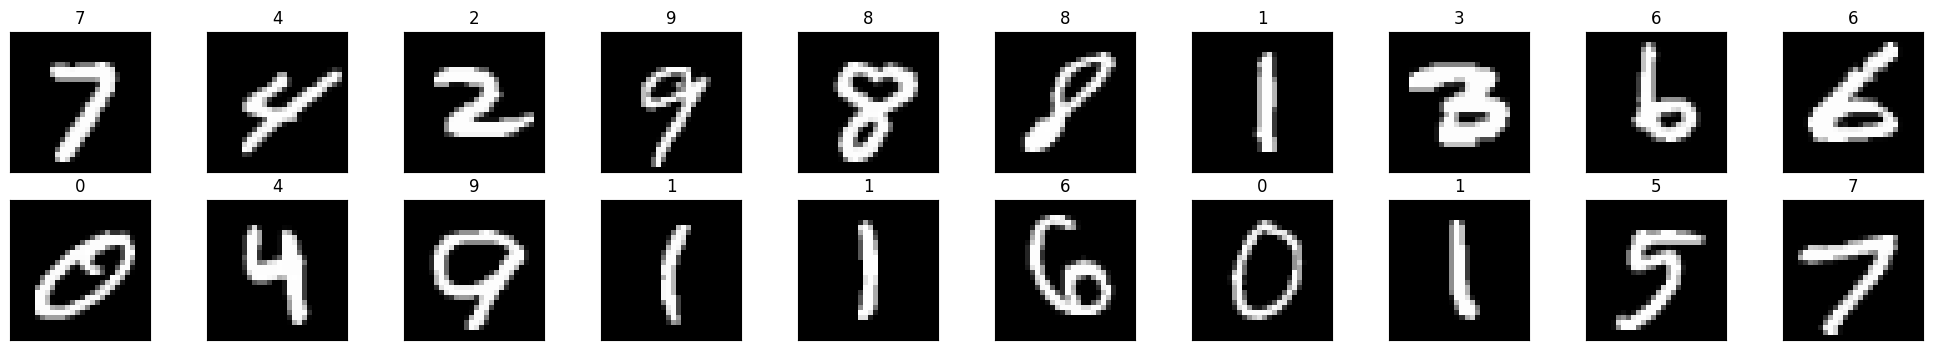

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# Obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()

# Plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20): # Plot 20 images
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[]) # Add a subplot for each image
    ax.imshow(np.squeeze(images[idx]), cmap='gray') # Squeeze the image into 2D
    ax.set_title(str(labels[idx].item())) # print out the correct label for each image; .item() gets the value contained in Tensor

### View an Image in More Detail  

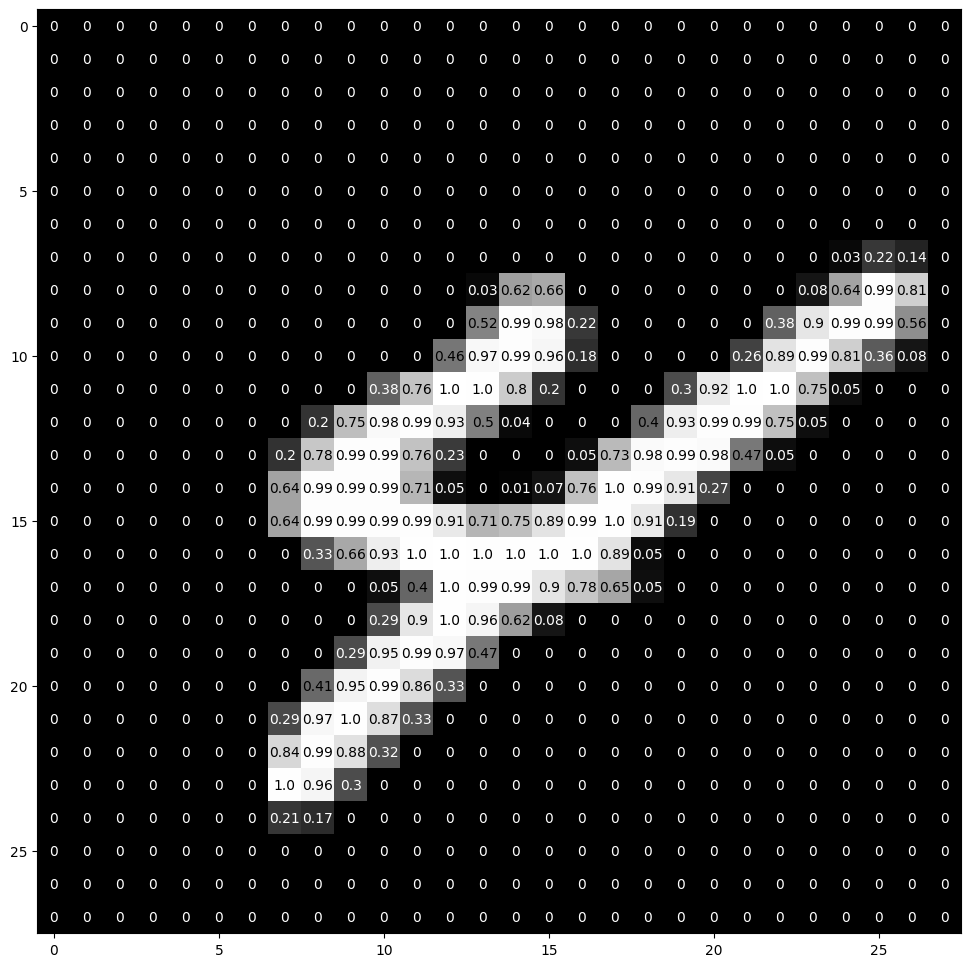

In [11]:
# Pick image from images, here 1. and squeeze the image into 2D
img = np.squeeze(images[1])

# Display the pixel values in this image
fig = plt.figure(figsize = (12,12)) # Set the figure size
ax = fig.add_subplot(111) # Add a subplot
ax.imshow(img, cmap='gray') # Display the image
width, height = img.shape # Get the dimensions of the image
thresh = img.max()/2.5 # Set a threshold to display the pixel values

# Display the pixel values in a 2D grid
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

## Define the Network Architecture

This code defines a neural network architecture for classifying images from the MNIST dataset. The neural network, named Net, consists of three fully connected (linear) layers. The first layer takes input from flattened 28x28 pixel images and has 512 hidden nodes, followed by a Rectified Linear Unit (ReLU) activation function. The second hidden layer also has 512 nodes and utilizes the ReLU activation function. The output layer has 10 nodes, corresponding to the 10 possible digit classes (0 to 9). Additionally, dropout layers with a dropout rate of 0.2 are applied after the first and second hidden layers to prevent overfitting during training. The model is printed to show its architecture.

In [12]:
import torch.nn as nn
import torch.nn.functional as F

# Define the NN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Number of hidden nodes in each layer
        hidden_1 = 512
        hidden_2 = 512

        # Define all layers
        self.fc1 = nn.Linear(28 * 28, hidden_1) # linear layer (784 -> hidden_1)
        self.fc2 = nn.Linear(hidden_1, hidden_2) # linear layer (n_hidden -> hidden_2)
        self.fc3 = nn.Linear(hidden_2, 10) # linear layer (n_hidden -> 10)
        self.dropout = nn.Dropout(0.2) # dropout layer (p=0.2) to prevent overfitting of data

    def forward(self, x):

        x = x.view(-1, 28 * 28) # flatten image input
        x = F.relu(self.fc1(x)) # pass through first hidden layer, with relu activation function
        x = self.dropout(x) # pass through dropout layer
        x = F.relu(self.fc2(x)) # pass through second hidden layer, with relu activation function
        x = self.dropout(x) # pass through second dropout layer
        x = self.fc3(x) # pass through output layer; note: as we use CrossEntropyLoss, we don't need to use softmax here
        return x
model = Net()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


###  Specify Loss Function and Optimizer

In [13]:
# Load the libraries
from torch import nn, optim

# Specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# Specify optimizer (stochastic gradient descent) and learning rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

## Train the Network


In [14]:
# Number of epochs to train the model
n_epochs = 50

# Initialize tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity

for epoch in range(n_epochs):
    # Monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # Train the model #
    ###################
    model.train() # Prep model for training

    for data, target in train_loader:
        # Clear the gradients of all optimized variables
        optimizer.zero_grad()
        # Forward pass: compute predicted outputs by passing inputs to the model
        output = model.forward(data)
        # Calculate the loss
        loss = criterion(output, target)
        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # Perform a single optimization step (parameter update)
        optimizer.step()
        # Update running training loss
        train_loss += loss.item()
        
    ######################    
    # Validate the model # 
    ######################
    model.eval() # prep model for evaluation

    for data, target in valid_loader:
        # Forward pass: compute predicted outputs by passing inputs to the model
        output = model.forward(data)
        # Calculate the loss
        loss = criterion(output, target)
        # Update running validation loss 
        valid_loss += loss.item()
        
    # Calculate average loss over an epoch
    train_loss = train_loss/len(train_loader)
    valid_loss = valid_loss/len(valid_loader)
    
    # Print training/validation statistics
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch+1, train_loss, valid_loss))
    
    # Save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.937316 	Validation Loss: 0.379530
Validation loss decreased (inf --> 0.379530).  Saving model ...
Epoch: 2 	Training Loss: 0.360214 	Validation Loss: 0.286302
Validation loss decreased (0.379530 --> 0.286302).  Saving model ...
Epoch: 3 	Training Loss: 0.285725 	Validation Loss: 0.236346
Validation loss decreased (0.286302 --> 0.236346).  Saving model ...
Epoch: 4 	Training Loss: 0.235814 	Validation Loss: 0.202175
Validation loss decreased (0.236346 --> 0.202175).  Saving model ...
Epoch: 5 	Training Loss: 0.199794 	Validation Loss: 0.174478
Validation loss decreased (0.202175 --> 0.174478).  Saving model ...
Epoch: 6 	Training Loss: 0.174301 	Validation Loss: 0.155585
Validation loss decreased (0.174478 --> 0.155585).  Saving model ...
Epoch: 7 	Training Loss: 0.154347 	Validation Loss: 0.138631
Validation loss decreased (0.155585 --> 0.138631).  Saving model ...
Epoch: 8 	Training Loss: 0.137957 	Validation Loss: 0.129292
Validation loss decreased (0.13863

###  Load the Model with the Lowest Validation Loss  


In [15]:
# Load the model that got the best validation accuracy
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

## Test the Trained Network


In [16]:
# Initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

# Prep model for *evaluation*
model.eval() 

for data, target in test_loader:
    # Forward pass: compute predicted outputs by passing inputs to the model
    output = model.forward(data)
    # Calculate the loss
    loss = criterion(output, target)
    # Update test loss 
    test_loss += loss.item()*data.size(0)
    # Convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # Compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    
    # Calculate test accuracy for EACH object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# Calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

# Calculate and print avg test accuracy
for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            class_correct[i], class_total[i]))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

# Calculate and print overall test accuracy
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.057502

Test Accuracy of     0: 99% (971/980)
Test Accuracy of     1: 99% (1127/1135)
Test Accuracy of     2: 98% (1013/1032)
Test Accuracy of     3: 98% (990/1010)
Test Accuracy of     4: 98% (968/982)
Test Accuracy of     5: 98% (875/892)
Test Accuracy of     6: 98% (944/958)
Test Accuracy of     7: 97% (1004/1028)
Test Accuracy of     8: 97% (946/974)
Test Accuracy of     9: 97% (985/1009)

Test Accuracy (Overall): 98% (9823/10000)


### Visualize Sample Test Results

This code visualizes a batch of test images along with their predicted and true labels using the trained neural network. It obtains one batch of test images, passes them through the model to get predictions, and then plots the images in a grid. The titles of each subplot display both the predicted and true labels for comparison. The titles are color-coded: green if the prediction matches the true label and red otherwise. This visualization provides a quick overview of the model's performance on the test set, highlighting correct and incorrect predictions for each image.

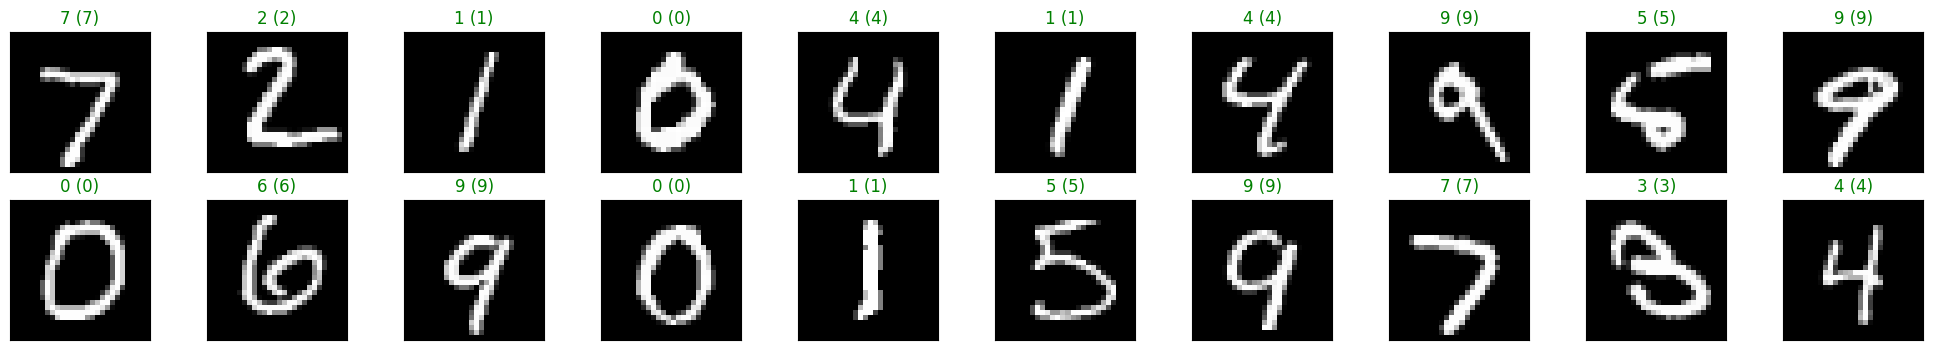

In [17]:
# Obtain one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Get sample outputs
output = model(images)
# Convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# Prep images for display
images = images.numpy()

# Plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))